In [546]:
from collections import Counter
from itertools import groupby
from itertools import zip_longest

import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import scipy as sp
import math
from scipy import special
%matplotlib inline

In [547]:
"""
The following defines all the texts as lists we can iterate over
"""

text_1 = list(open("englishtext.txt",encoding='utf8').read())
text_2 = [' ' if x=='\n' else x for x in text_1]
text = [x.lower() for x in text_2]

seen = text[0]
cleaned_text = [text[0]]
for i in text[1:]:
    if i == ' ':
        if i != seen:
            cleaned_text.append(i)
        seen = i
    else:
        cleaned_text.append(i)
        seen = i
    

symbols_1 = list(open("symbols.txt",encoding='utf8').read())
symbols = list(filter(('\n').__ne__, symbols_1))
symbol_set = set(symbols)
symbol_pairs = []
for i in symbols:
    for j in symbols:
        symbol_pairs.append((i,j))

symbol_pairs_set = set(symbol_pairs)

['=', ' ', '-', ',', ';', ':', '!', '?', '/', '.', "'", '"', '(', ')', '[', ']', '*', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [548]:
message_1 = list(open('message.txt',encoding='utf8').read())
message = list(filter(('\n').__ne__, message_1))

In [590]:
dictionary_1 = dict(Counter(cleaned_text))

In [550]:
"""
cleaned_dict contains counts of all 53 symbols and no others
"""
cleaned_dict = dict((k, dictionary_1[k]) for k in set(dictionary_1) & symbol_set)

In [591]:
"""
cleaned_dict_pairs contains counts of every consecutively occurring pairs of symbols (in both orders)
symbol_pairs is a list of all possible pair combinations (both orders included) 
"""
dict_pairs = Counter(zip(cleaned_text, cleaned_text[1:]))
cleaned_dict_pairs = dict((k,dict_pairs[k]) for k in set(dict_pairs) & symbol_pairs_set)

In [592]:
"""
define transition matrix full of zeros
resulting is matrix P where P[i][j] is proportional to prob from going from i to j (row to column)
"""

P = torch.zeros((53,53))

for i in range(53):
    for j in range(53):
        try:
            P[i][j] = cleaned_dict_pairs[(symbols[i],symbols[j])]
        except KeyError:
            pass
        
"""
defines a different matrix for test case
"""

test_P = (torch.ones_like(P) + P).t()

In [555]:
"""
count_vector contains a vector of counts of the symbols (in the same order as P)
"""
count_vector = torch.zeros(53)
for i in range(53):
    count_vector[i] = cleaned_dict[symbols[i]]

In [594]:
"""
we normalise the rows of P to sum to 1, then transpose to get the transition matrix
"""
normalisers = torch.sum(P,1)
normalised_P = (torch.diag(torch.div(torch.ones(normalisers.size()),normalisers)) @ P).t()

In [595]:
"""
the transition matrix estimate is not aperiodic (and may not be irreducible),
we make it aperiodic and irreducible by adding a*torch.ones(P.size()) to P.
where 'a' is decided by heuristics, we choose a=min(P)\0. we then normalise to make
the columns sum to one
"""

"\nthe transition matrix estimate is not aperiodic (and may not be irreducible),\nwe make it aperiodic and irreducible by adding a*torch.ones(P.size()) to P.\nwhere 'a' is decided by heuristics, we choose a=min(P)\x00. we then normalise to make\nthe columns sum to one\n"

In [596]:
"""
finds the minimum value excluding 0 in the transition matrix
"""
minimum = 1
count= 0
for i in normalised_P:
    for j in range(53):
        if i[j] != 0 and i[j]<minimum:
            minimum = i[j]

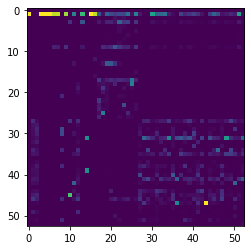

In [558]:
regulariser = minimum*torch.ones_like(normalised_P)
irrep_P = normalised_P + regulariser

row_normalisers = torch.sum(irrep_P,0)
transition_M = irrep_P @ torch.diag(torch.div(torch.ones_like(row_normalisers),row_normalisers))

plt.imshow(transition_M, interpolation='nearest')
plt.savefig('transitionm.png')
plt.show()


In [597]:
"""
we now find the stationary distribution
"""

init_p_1 = torch.full((53,),1/53)

for _ in range(100):
    init_p_1 = transition_M @ init_p_1

In [598]:
stat_p = init_p_1
print(torch.sum(stat_p))

tensor(1.0000)


In [588]:
"""
create a dictionary for the stationary distribution
"""

list_1 = [x.item() for x in stat_p]
invariant_dict = dict(zip(symbols,list_1))

In [490]:
print ("{:<8} {:<15}".format('Symbol','invariant probability'))
for k,v in invariant_dict.items():
    print("{:<8} {:<15}".format(k, '{:.3e}'.format(v)))

Symbol   invariant probability
=        2.438e-06      
         1.793e-01      
-        5.821e-04      
,        1.260e-02      
;        3.608e-04      
:        3.208e-04      
!        1.243e-03      
?        9.887e-04      
/        4.709e-06      
.        1.001e-02      
'        4.016e-06      
"        8.886e-06      
(        2.156e-04      
)        2.139e-04      
[        2.438e-06      
]        2.582e-06      
*        9.462e-05      
0        6.155e-05      
1        1.299e-04      
2        4.880e-05      
3        2.129e-05      
4        9.389e-06      
5        1.900e-05      
6        2.051e-05      
7        1.511e-05      
8        6.533e-05      
9        1.346e-05      
a        6.423e-02      
b        1.090e-02      
c        1.951e-02      
d        3.751e-02      
e        9.940e-02      
f        1.746e-02      
g        1.622e-02      
h        5.314e-02      
i        5.426e-02      
j        8.124e-04      
k        6.357e-03      
l        3.018e-02 

In [599]:
"""
a dictionary specifying the order of the symbols in the transition matrix and
invariant distribution (key is symbol, key-value is index in matrix/vector)
"""

master_dict = dict(zip(symbols,range(0,53)))

In [600]:
"""
dictionary corresponding to the identity permutation (for test cases)
"""
def identity_perm():
    identity_perm = dict(zip(symbols,symbols)), [symbols,symbols]
    return identity_perm

In [601]:
"""
initialise random permutation
"""
def init_perm():
    L = [0,0]
    L_1 = symbols
    L_0 = random.sample(symbols,53)
    
    L[0] = L_0
    L[1] = L_1
    return dict(zip(L_0,L_1)), L

In [562]:
"""
returns the invariant probability of the pre-image of a message symbol under
some permutation
"""
def invariant_prob_preimage(a,perm):
    index = master_dict[perm[a]]
    return stat_p[index]

In [563]:
"""
returns the element of transition matrix indexed by the pre-images of of two message
symbols under some permutation
"""
def transition_prob_preimages(a,b,perm):
    index_1, index_2 = master_dict[perm[b]], master_dict[perm[a]]
    
    #return transition_M[index_1][index_2]
    return test_P[index_1][index_2]


In [564]:
"""
finds the log-likelihood of the message given a permutation
"""
def log_likelihood(perm):
    """log_prob = torch.log(invariant_prob_preimage(message[0],perm))
    for i in range(len(message)-1):
        log_prob += torch.log(transition_prob_preimages(message[i],message[i+1],perm))"""
    
    log_prob = 0
    for i in range(len(message)-1):
        log_prob += torch.log(transition_prob_preimages(message[i],message[i+1],perm))
    
    return log_prob

In [576]:
"""
swaps two random symbols to generate a new permutation
"""
def swap_values(u,v):
    a, b = random.randrange(53), random.randrange(53)
    while a == b:
        a, b = random.randrange(53), random.randrange(53)
    
    new_u = u.copy()
    new_v = v.copy()
    
    symbol_1 = v[0][a]
    symbol_2 = v[0][b]
    
    
    new_v[0][a] = symbol_2
    new_v[0][b] = symbol_1
     
    a = u[symbol_1]
    b = u[symbol_2]
    
    new_u[symbol_1] = b
    new_u[symbol_2] = a
    
    return new_u, new_v


"""test_u = identity_perm()[0]
test_v  = identity_perm()[1]
test_swap = swap_values(test_u,test_v)
print(test_u)
print(test_swap[0])
print(test_v)
print(test_swap[1])"""


'test_u = identity_perm()[0]\ntest_v  = identity_perm()[1]\ntest_swap = swap_values(test_u,test_v)\nprint(test_u)\nprint(test_swap[0])\nprint(test_v)\nprint(test_swap[1])'

In [573]:
"""
print the message given some permutation
"""
def print_decrypted_message(perm,length):
    replacer = perm.get
    
    message_list = [replacer(n,n) for n in message]
    decrypted_message = ""
    for x in message_list:
        decrypted_message += x
    print(decrypted_message[:length])

In [569]:
"""
returns boolean specifying whether to go from permutation t to permutation t+1
"""

def acceptance(perm_1,perm_2):
    a = log_likelihood(perm_2).item()
    b = log_likelihood(perm_1).item()
    """print(a)
    print(b)
    print(a-b)"""
    log_ratio = a - b
    """print(log_ratio)"""
    log_acceptance_prob = min(0,log_ratio)
    """print(log_acceptance_prob)"""
    a = dist.Uniform(0,1).sample()
    """print(math.log(a))"""
    if math.log(a) <= log_acceptance_prob:
        return True
    else:
        return False

In [570]:
"""
defines one round of the MCMC sampler, starting from some starting permutation
"""
def MCMC_round(perm_dict,perm_list):
    new_dict, new_list = swap_values(perm_dict,perm_list)
    if acceptance(perm_dict,new_dict):
        return new_dict, new_list
    else:
        return perm_dict, perm_list

In [584]:
def MCMC(N_iter):
    perm_dict, perm_list = init_perm()
    for i in range(N_iter):
        perm_dict, perm_list = MCMC_round(perm_dict,perm_list)
        if i%100 == 0:
            print_decrypted_message(perm_dict,60)
        if i == N_iter-1:
            print_decrypted_message(perm_dict,len(message))
    

In [602]:
MCMC(20001)

v:!g;!;?1:m=,!2:h!g?,=! 1w:=,2yw=!;=2,i!g;![2q*=,!m2 =!g=!i?
s;ig:i:z ;mfuit;higzufi, a;futyafi:ftueig:icto8fuimt,figfiez
n il:i:b; vfuit hilbufi,;a futpafi:ftueil:ictosfuivt,filfieb
s ilwiwc; vruit hilcuri,;a rutmariwrtueilwidtonruivt,rilriec
s ilwiwnm druit hilnuriyma rut;ariwrtueilwivtocruidtyrilrien
s ifwiwng pruit hifnuriyga rut;ariwrtueifwivtocruiptyrifrien
s efwewng prcet hefncredga rct!arewrtciefwevtourceptdrefrein
s efwewng prcet hefncredgl rct!lrewrtciefwevtourceptdrefrein
s efwewng prcet hefncredgl rct!lrewrtciefwevtourceptdrefrein
s eawewng prcet heancredgl rct!lrewrtcieawevtourceptdrearein
r eawewng pslet heanlsedgc slt!csewstlieawevtousleptdseasein
re aw wndepsl teh anls fdceslt(cs wstli aw vtousl ptfs as in
re aw wndepil tey anli fdceiltbci witls aw vtouil ptfi ai sn
re aw wndepil tey anli fdceiltbci witls aw vtouil ptfi ai sn
re aw wndepil tey anli vdceiltbci witls aw ftouil ptvi ai sn
re aw wndepil tey anli vdceiltbci witls aw ftouil ptvi ai sn
re aw wndepil tey anli v

in dy younger anm dore vulnerable years dy father gave de so
in dy younger anm dore vulnerawle years dy father gave de so
in dy younger anm dore vulnerawle years dy father gave de so
in dy younger anm dore vulnerawle years dy father gave de so
in dy younger anm dore vulnerawle years dy father gave de so
in dy younger anm dore vulnerawle years dy father gave de so
in dy younger anm dore vulnerawle years dy father gave de so
in dy younger anm dore vulnerawle years dy father gave de so
in dy younger anm dore vulnerawle years dy father gave de so
in dy younger anm dore vulnerawle years dy father gave de so
in my younger and more vulnerable years my father gave me so
in my younger and more vulnerable years my father gave me so
in my younger and more vulnerable years my father gave me so
in my younger and more vulnerable years my father gave me so
in my younger and more vulnerable years my wather gave me so
in my younger and more vulnerable years my wather gave me so
in my younger and more v